# Machine Learning Project: Predicting Titanic Survivors

In this project we'll evaluate Titanic survivorship data from a Kaggle competition, and train and test a few different models to best predict which passengers surived or perished from a holdout (label removed) dataset. The goal is to demonstrate how to use data cleaning, feature selection, model selection, and hyperparameter tuning to build the most predictive machine learning algorithm possible.

In [1]:
import pandas as pd

#Import the datasets
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


We defined a bunch of dataset specific cleaning functions in past exercises. Let's load those for use here.

In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
#We'll now build a function that calls each of these against the training/holdout dataframes

def clean_titanic(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    for col in ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]:
        df = create_dummies(df, col)
    return df

train = clean_titanic(train)
holdout = clean_titanic(holdout)

In [4]:
#Let's explore the SibSp and Parch columns, which contain information about a passenger's family on board.

print(train['SibSp'].value_counts())
print(train['Parch'].value_counts())

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


<AxesSubplot:ylabel='Frequency'>

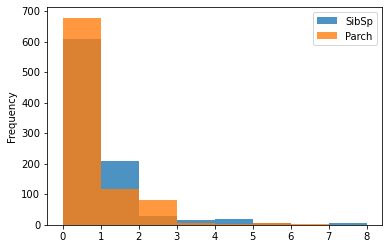

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

train[['SibSp', 'Parch']].plot.hist(alpha=0.8, bins=8)

Text(0.5, 0, '# of Siblings and Spouses')

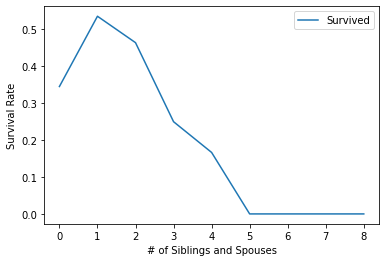

In [6]:
train.pivot_table('Survived', index='SibSp').plot()
plt.ylabel('Survival Rate')
plt.xlabel('# of Siblings and Spouses')

Text(0.5, 0, '# of Parents and Children')

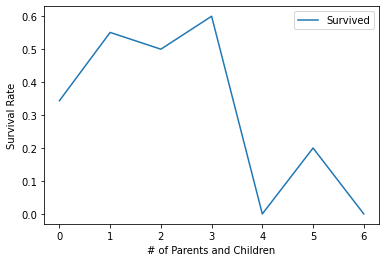

In [7]:
train.pivot_table('Survived', index='Parch').plot()
plt.ylabel('Survival Rate')
plt.xlabel('# of Parents and Children')

<AxesSubplot:ylabel='Frequency'>

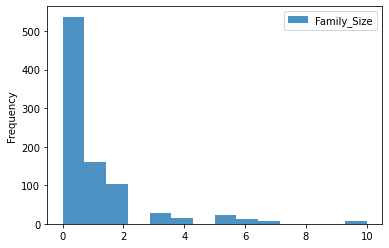

In [8]:
#Combine columns to make a Family Size column

train['Family_Size'] = train['SibSp'] + train['Parch']
holdout['Family_Size'] = holdout['SibSp'] + holdout['Parch']

train[['Family_Size']].plot.hist(alpha=0.8, bins=14)

Text(0.5, 0, '# of Family On Board')

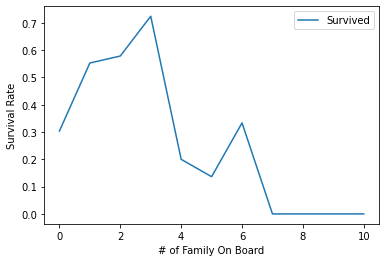

In [9]:
train.pivot_table('Survived', index='Family_Size').plot()
plt.ylabel('Survival Rate')
plt.xlabel('# of Family On Board')

Text(0.5, 0, 'Passenger Class')

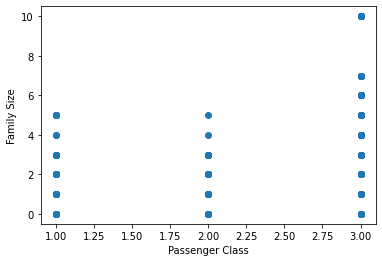

In [10]:
plt.scatter(x=train['Pclass'], y=train['Family_Size'])
plt.ylabel('Family Size')
plt.xlabel('Passenger Class')

In [11]:
len(train[train['Family_Size'] ==0]) / len(train)

0.6026936026936027

Most passengers were alone (60%) on the Titanic, and of those that had family, the vast majority had 1 to 2 family members on board. Those with 1-3 family members had the highest rates of surival (55-70%), whereas passengers with larger families fared worse. This could be explained with passenger class - the only passengers with >5 family members on board were all 3rd class passengers. Passengers traveling alone surived only ~30% of the time...

In [12]:
#Categorize passengers as either traveling alone or not.
train['isalone'] = train['Family_Size'] == 0
train['isalone'] = train['isalone']*1
holdout['isalone'] = holdout['Family_Size'] == 0
holdout['isalone'] = holdout['isalone']*1

Let's now do some recursive feature elimination using scikit-learn's built in RFECV class.

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    #Remove non-numeric columns, and columns with any null values
    df = df.select_dtypes(include='number').dropna(axis=1)
    
    #Split dataframe into features (all_X) and target (all_y)
    all_X = df.drop(['PassengerId', 'Survived'], axis=1)
    all_y = df['Survived']
    
    #Select the best features to use in a Random Forest
    estimator = RandomForestClassifier(random_state=1)
    selector = RFECV(estimator, cv=10)
    selector.fit(all_X, all_y)
    
    best_columns = all_X.columns[selector.support_]
    
    print(best_columns)
    return best_columns

In [14]:
best_rf_columns = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'Family_Size'],
      dtype='object')


Let's use the GridSearchCV class from scikit-learn to now find the best performing set of models-parameters from 3 model types (Logistic Regression, K Nearest Neighbors, Random Forest).

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

def select_model(df,features):
    all_X = df[features]
    all_y = df['Survived']
    
    #Dataquest provides a list of hyperparameters to search through. Put them in a dictionary.
    models = [
        {"name": "LogisticRegression",
         "estimator": LogisticRegression(),
         "hyperparameters":
             {
                 "solver": ["newton-cg","lbfgs","liblinear"]
             }
        },
        {"name": "KNeighborsClassifier",
         "estimator": KNeighborsClassifier(),
         "hyperparameters":
             {
                 "n_neighbors": range(1,20,2),
                 "weights": ["distance", "uniform"],
                 "algorithm": ["ball_tree", "kd_tree", "brute"],
                 "p": [1,2]
             }
        },
        {"name": "RandomForestClassifier",
         "estimator": RandomForestClassifier(),
         "hyperparameters":
             {
                 "n_estimators": [4, 6, 9],
                 "criterion": ["entropy", "gini"],
                 "max_depth": [2, 5, 10],
                 "max_features": ["log2", "sqrt"],
                 "min_samples_leaf": [1, 5, 8],
                 "min_samples_split": [2, 3, 5]
             }
        },
    ]
    for model in models:
        print(model['name'])
        estimator = model['estimator']
        grid = GridSearchCV(estimator, param_grid=model['hyperparameters'],cv=10)
        grid.fit(all_X, all_y)
        #Assign parameters and score for the best model in the dictionary, best estimator to the dictionary
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_estimator'] = grid.best_estimator_
        print('Best Estimator: {}'.format(model['best_estimator']))
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}".format(model["best_params"]))
        
    return models

In [16]:
model_performances = select_model(train, best_rf_columns)

LogisticRegression


C:\Users\guestaccount\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\guestaccount\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Best Estimator: LogisticRegression(solver='newton-cg')
Best Score: 0.821598002496879
Best Parameters: {'solver': 'newton-cg'}
KNeighborsClassifier
Best Estimator: KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7, p=1)
Best Score: 0.7822971285892635
Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
RandomForestClassifier
Best Estimator: RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       n_estimators=9)
Best Score: 0.8417852684144819
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9}


Our RandomForestClassifier performed best (84.2% accuracy). Let's submit to Kaggle.

In [17]:
def save_submission_file(model,cols,filename='submission.csv'):
    predictions = model.predict(holdout[cols])
    submission = pd.DataFrame({'PassengerId':holdout['PassengerId'],'Survived': predictions})
    submission.to_csv(filename,index=False)

In [19]:
save_submission_file(model_performances[2]['best_estimator'],best_rf_columns)

OK - achieved a 77.5% accuracy after submitting to Kaggle, placing me in the middle of the pack (ha!). While there are a LOT of cheaters (100% accuracy probably means downloading the labeled source data and just uploading "predictions" that match exactly that list), I could spend more time: (a) refining my features and/or (b) possibly using a different model that's less likely to overfit (decision trees/random forests tend to overfit more than logistic regressions for example). But I'm satisfied enough for now!